In [1]:
import json
import glob
import numpy as np
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, shuffle
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [2]:
DATA_DIR = "../data/" 
AUGMENTATION_FACTOR = 15 # Increased to generate more shifted variations
BATCH_SIZE = 16          # Smaller batch size helps generalization on small datasets

In [3]:
def extract_features(line_json):
    try:
        data = json.loads(line_json)
        
        # --- A. Thermal Image (8x24) ---
        if 'left' not in data['thermal']: return None, None
        
        img_left = np.array(data['thermal']['left'], dtype=np.float32).reshape(8, 8)
        img_center = np.array(data['thermal']['center'], dtype=np.float32).reshape(8, 8)
        img_right = np.array(data['thermal']['right'], dtype=np.float32).reshape(8, 8)
        
        # Stitch: (8, 24)
        full_img = np.concatenate([img_left, img_center, img_right], axis=1)
        
        # --- FIX: Per-Frame Normalization ---
        # Zero-center the image based on its own mean temperature
        frame_mean = np.mean(full_img)
        full_img = full_img - frame_mean
        
        img_feat = np.expand_dims(full_img, axis=-1)

        # --- B. Scalars (Radar + Mic) ---
        scalars = []
        radar_source = data.get('mmWave', data.get('radar', {}))
        r1 = radar_source.get('R1', radar_source.get('left', {}))
        r2 = radar_source.get('R2', radar_source.get('right', {}))

        # Default to 0 if missing
        scalars.extend([r1.get('energy',0), float(r1.get('range',0)), float(r1.get('speed',0))])
        scalars.extend([r2.get('energy',0), float(r2.get('range',0)), float(r2.get('speed',0))])
        
        # Mic
        mic = data.get('mic', {})
        scalars.append(mic.get('left', 0.0))
        scalars.append(mic.get('right', 0.0))
        
        return img_feat, np.array(scalars, dtype=np.float32)
        
    except Exception:
        return None, None

In [4]:
# ==========================================
# 3. DATA LOADING
# ==========================================
print("--- 1. Loading & Splitting Files ---")
files_neg = glob.glob(os.path.join(DATA_DIR, "data_label_0*.jsonl"))
files_pos = glob.glob(os.path.join(DATA_DIR, "data_label_1*.jsonl"))

random.seed(42)
random.shuffle(files_neg)
random.shuffle(files_pos)

# File-based split to prevent data leakage
split_idx_neg = int(len(files_neg) * 0.8)
split_idx_pos = int(len(files_pos) * 0.8)

train_files = files_neg[:split_idx_neg] + files_pos[:split_idx_pos]
test_files = files_neg[split_idx_neg:] + files_pos[split_idx_pos:]

def load_dataset_from_files(file_list):
    X_img, X_scal, Y = [], [], []
    for f_path in file_list:
        label = 1.0 if "label_1" in f_path else 0.0
        with open(f_path, 'r') as f:
            for line in f:
                img, scal = extract_features(line)
                if img is not None:
                    X_img.append(img)
                    X_scal.append(scal)
                    Y.append(label)
    return np.array(X_img, dtype=np.float32), np.array(X_scal, dtype=np.float32), np.array(Y, dtype=np.float32)

X_img_train, X_scal_train, y_train = load_dataset_from_files(train_files)
X_img_test, X_scal_test, y_test = load_dataset_from_files(test_files)

print(f"✅ Train: {len(y_train)} | Test: {len(y_test)}")

--- 1. Loading & Splitting Files ---
✅ Train: 2587 | Test: 958


In [5]:
# ==========================================
# 4. SMART AUGMENTATION
# ==========================================
# Crucial: We add SPATIAL SHIFTS so the model learns objects can be anywhere
if AUGMENTATION_FACTOR > 0:
    print(f"--- Augmenting Data (x{AUGMENTATION_FACTOR}) ---")
    aug_img, aug_scal, aug_y = [], [], []
    
    for i in range(len(y_train)):
        # Add Original
        aug_img.append(X_img_train[i])
        aug_scal.append(X_scal_train[i])
        aug_y.append(y_train[i])
        
        for _ in range(AUGMENTATION_FACTOR):
            new_img = X_img_train[i].copy()
            new_scal = X_scal_train[i].copy()
            
            # 1. Spatial Shift (Left/Right) - Simulates animal moving
            # Shape is (8, 24, 1). Axis 1 is width.
            shift_px = random.randint(-3, 3) 
            new_img = np.roll(new_img, shift_px, axis=1)
            
            # 2. Noise Injection
            new_img += np.random.normal(0, 0.2, new_img.shape) 
            new_scal += np.random.normal(0, 0.05, new_scal.shape)
            
            aug_img.append(new_img)
            aug_scal.append(new_scal)
            aug_y.append(y_train[i])
            
    X_img_train = np.array(aug_img, dtype=np.float32)
    X_scal_train = np.array(aug_scal, dtype=np.float32)
    y_train = np.array(aug_y, dtype=np.float32)

X_img_train, X_scal_train, y_train = shuffle(X_img_train, X_scal_train, y_train, random_state=42)

--- Augmenting Data (x15) ---


In [6]:
# ==========================================
# 5. NORMALIZATION
# ==========================================
mean_scal = np.mean(X_scal_train, axis=0)
std_scal = np.std(X_scal_train, axis=0)
std_scal[std_scal == 0] = 1.0

X_scal_train = (X_scal_train - mean_scal) / std_scal
X_scal_test = (X_scal_test - mean_scal) / std_scal

# Export header
with open("normalization_values.h", "w") as f:
    f.write("#ifndef NORM_H\n#define NORM_H\n")
    f.write("const float SCALAR_MEAN[]={"+",".join([f"{x:.4f}" for x in mean_scal])+"};\n")
    f.write("const float SCALAR_STD[]={"+",".join([f"{x:.4f}" for x in std_scal])+"};\n#endif")

In [7]:
# ==========================================
# 6. ROBUST MODEL ARCHITECTURE
# ==========================================
# Input A: Thermal
input_img = Input(shape=(8, 24, 1), name="thermal")

# Layer 1: Capture basic edges/blobs
# Increased filters to 16 to capture more shapes
x1 = Conv2D(16, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(input_img)
x1 = MaxPooling2D((2, 2))(x1) 

# Layer 2: Capture complex shapes (legs, heads)
# Increased filters to 32
x1 = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(x1)
x1 = GlobalAveragePooling2D()(x1) 

# Input B: Scalars
input_scal = Input(shape=(X_scal_train.shape[1],), name="scalars")
x2 = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(input_scal)
x2 = BatchNormalization()(x2)

# Fusion
combined = Concatenate()([x1, x2])

# Dense Block
z = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(combined)
# Reduced Dropout to 0.3. 
# 0.6 was too high, causing the model to lack confidence (outputting < 0.4).
z = Dropout(0.3)(z) 

output = Dense(1, activation='sigmoid')(z)

model = Model(inputs=[input_img, input_scal], outputs=output)

In [8]:
# ==========================================
# 7. TRAINING
# ==========================================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw_dict = dict(enumerate(cw))

callbacks = [
    ModelCheckpoint("best_model_farm.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
]

print("\n--- Starting Training ---")
history = model.fit(
    [X_img_train, X_scal_train], y_train,
    validation_data=([X_img_test, X_scal_test], y_test),
    epochs=30, 
    batch_size=BATCH_SIZE,
    class_weight=cw_dict,
    callbacks=callbacks
)


--- Starting Training ---
Epoch 1/30
2565/2587 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7014 - loss: 0.5950
Epoch 1: val_accuracy improved from None to 0.79645, saving model to best_model_farm.keras
2587/2587 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7859 - loss: 0.4708 - val_accuracy: 0.7965 - val_loss: 0.5149 - learning_rate: 5.0000e-04
Epoch 2/30
2557/2587 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9017 - loss: 0.3092
Epoch 2: val_accuracy improved from 0.79645 to 0.91754, saving model to best_model_farm.keras
2587/2587 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9156 - loss: 0.2855 - val_accuracy: 0.9175 - val_loss: 0.2400 - learning_rate: 5.0000e-04
Epoch 3/30
2587/2587 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9410 - loss: 0.2333
Epoch 3: val_accuracy did not improve from 0.91754
2587/2587 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9432 - loss: 0.2229 - val_accuracy: 0.7923 - val_loss: 0.6719 - learning_rate: 5.0000e-04
Epoch 4/30
2584/2587 ━━━━━━━━━━━

In [9]:
# ==========================================
# 8. EVALUATION & EXPORT
# ==========================================
print("\n--- Evaluation on Test Set ---")
loss, acc = model.evaluate([X_img_test, X_scal_test], y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

# Generate TFLite
def representative_data_gen():
    for i in range(min(100, len(X_img_train))):
        yield [X_img_train[i:i+1], X_scal_train[i:i+1]]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()
with open("model_final.tflite", "wb") as f: f.write(tflite_model)

# Header Generation
data = tflite_model
hex_array = ", ".join([f"0x{b:02x}" for b in data])
with open('model.h','w') as f:
    f.write("#ifndef MODEL_H\n#define MODEL_H\n#include <Arduino.h>\n\n")
    f.write(f"alignas(16) const unsigned char model_tflite[] = {{ {hex_array} }};\n")
    f.write(f"const unsigned int model_tflite_len = {len(data)};\n\n#endif\n")

print("✅ Done! Copy model.h and model_normalization.h to your firmware.")


--- Evaluation on Test Set ---
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9353 - loss: 0.2282 
Test Accuracy: 93.53%
INFO:tensorflow:Assets written to: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpyr6fynaj/assets


INFO:tensorflow:Assets written to: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpyr6fynaj/assets


Saved artifact at '/var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpyr6fynaj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 8, 24, 1), dtype=tf.float32, name='thermal'), TensorSpec(shape=(None, 8), dtype=tf.float32, name='scalars')]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  5969273680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5969265760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5969277904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6014665120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5969275440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5969276672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6014668992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6014670752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6014668288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6014668464: TensorSpec(s

/Users/wanghley/miniconda3/envs/agronaults/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1764179436.428741  307431 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1764179436.428750  307431 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-11-26 12:50:36.429643: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpyr6fynaj
2025-11-26 12:50:36.430281: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-11-26 12:50:36.430287: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/r5/m5977dy13hd_9klxgsmylm740000gn/T/tmpyr6fynaj
I0000 00:00:1764179436.434205  307431 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2025-11-26 1

✅ Done! Copy model.h and model_normalization.h to your firmware.


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8
2025-11-26 12:50:36.531628: W tensorflow/compiler/mlir/lite/flatbuffer_export.cc:3705] Skipping runtime version metadata in the model. This will be generated by the exporter.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def find_optimal_threshold(model, X_data, y_true, start=0.1, end=0.9, step=0.01):
    """
    Scans thresholds from start to end to find the one that maximizes F1 Score.
    """
    print("--- Scanning for Best Decision Threshold ---")
    
    # 1. Get raw probabilities (0.0 to 1.0)
    # Note: We use the list [X_img, X_scal] because your model is dual-input
    y_pred_prob = model.predict(X_data, verbose=0)
    
    thresholds = np.arange(start, end, step)
    f1_scores = []
    precisions = []
    recalls = []
    accuracies = []
    
    best_thresh = 0.5
    best_f1 = 0.0
    
    for t in thresholds:
        # Apply threshold
        y_pred_bin = (y_pred_prob > t).astype(int)
        
        # Calculate metrics
        f1 = f1_score(y_true, y_pred_bin, zero_division=0)
        prec = precision_score(y_true, y_pred_bin, zero_division=0)
        rec = recall_score(y_true, y_pred_bin, zero_division=0)
        acc = accuracy_score(y_true, y_pred_bin)
        
        f1_scores.append(f1)
        precisions.append(prec)
        recalls.append(rec)
        accuracies.append(acc)
        
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t

    # 2. Print Results
    print(f"✅ Best Threshold (Max F1): {best_thresh:.2f}")
    
    # Get metrics at best threshold
    idx = np.where(thresholds == best_thresh)[0][0]
    print(f"   - F1 Score:  {f1_scores[idx]:.4f}")
    print(f"   - Precision: {precisions[idx]:.4f} (Trustworthiness)")
    print(f"   - Recall:    {recalls[idx]:.4f} (Sensitivity)")
    print(f"   - Accuracy:  {accuracies[idx]:.4f}")

    # 3. Visualize the Trade-off
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label='Precision (Low False Positives)', linestyle='--', color='blue')
    plt.plot(thresholds, recalls, label='Recall (Low False Negatives)', linestyle='--', color='green')
    plt.plot(thresholds, f1_scores, label='F1 Score (Balance)', linewidth=3, color='red')
    
    plt.axvline(best_thresh, color='black', linestyle=':', label=f'Best: {best_thresh:.2f}')
    plt.title("Threshold Selection Curve")
    plt.xlabel("Decision Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return best_thresh

--- Scanning for Best Decision Threshold ---
✅ Best Threshold (Max F1): 0.73
   - F1 Score:  0.9462
   - Precision: 0.9474 (Trustworthiness)
   - Recall:    0.9450 (Sensitivity)
   - Accuracy:  0.9551


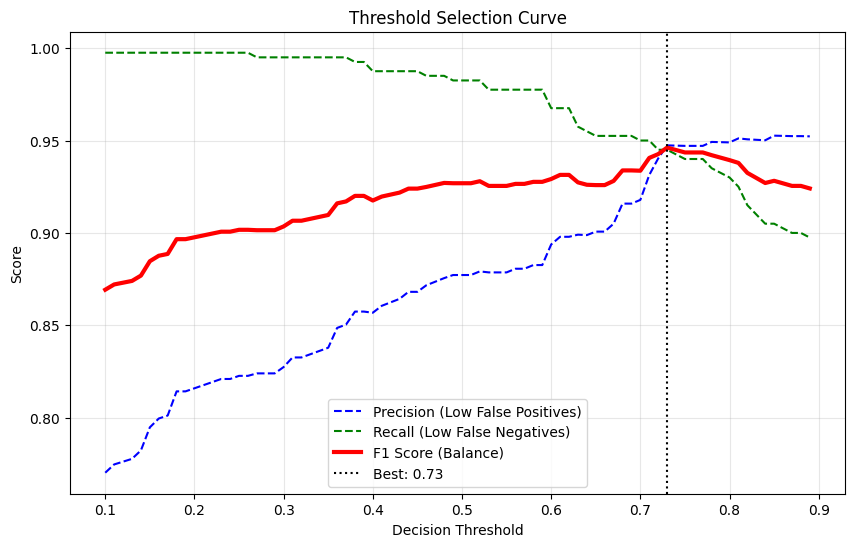

In [11]:
optimal_t = find_optimal_threshold(model, [X_img_test, X_scal_test], y_test)